In [1]:
import os

try:
    snakemake
except NameError:
    from snakemk_util import load_rule_args
    
    os.chdir('../..')
    
    snakemake = load_rule_args(
        snakefile = os.getcwd() + "/workflow/Snakefile",
        rule_name = 'pas_replication_rate',
        root = '..'
    )

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
from lapa.result import LapaResult

In [3]:
df_pas = snakemake.params['df_pas']

In [4]:
lapa = LapaResult(snakemake.input['lapa_dir'], replicated=False)

In [5]:
def get_samples(dataset):
    return df_pas[df_pas['Biosample term name'] == dataset].index.tolist()

In [6]:
df_thresholds = list()

for dataset in tqdm(lapa.datasets):

    df_thresholds.append({
        'biosample': dataset,
        'threshold': lapa.read_dataset(dataset)['count'].min(),
        'num_replicates': len(get_samples(dataset))
    })
    
df_thresholds = pd.DataFrame(df_thresholds)

  0%|          | 0/4 [00:00<?, ?it/s]

In [7]:
df_thresholds.to_csv(snakemake.output['table_threshold'], index=False)

In [8]:
df_thresholds = df_thresholds[df_thresholds['num_replicates'] > 1]

In [9]:
df_thresholds

,biosample,threshold,num_replicates
0,GM12878,113,2
1,H1,46,3
2,WTC11,32,3
3,endodermal cell,56,3


  0%|          | 0/4 [00:00<?, ?it/s]

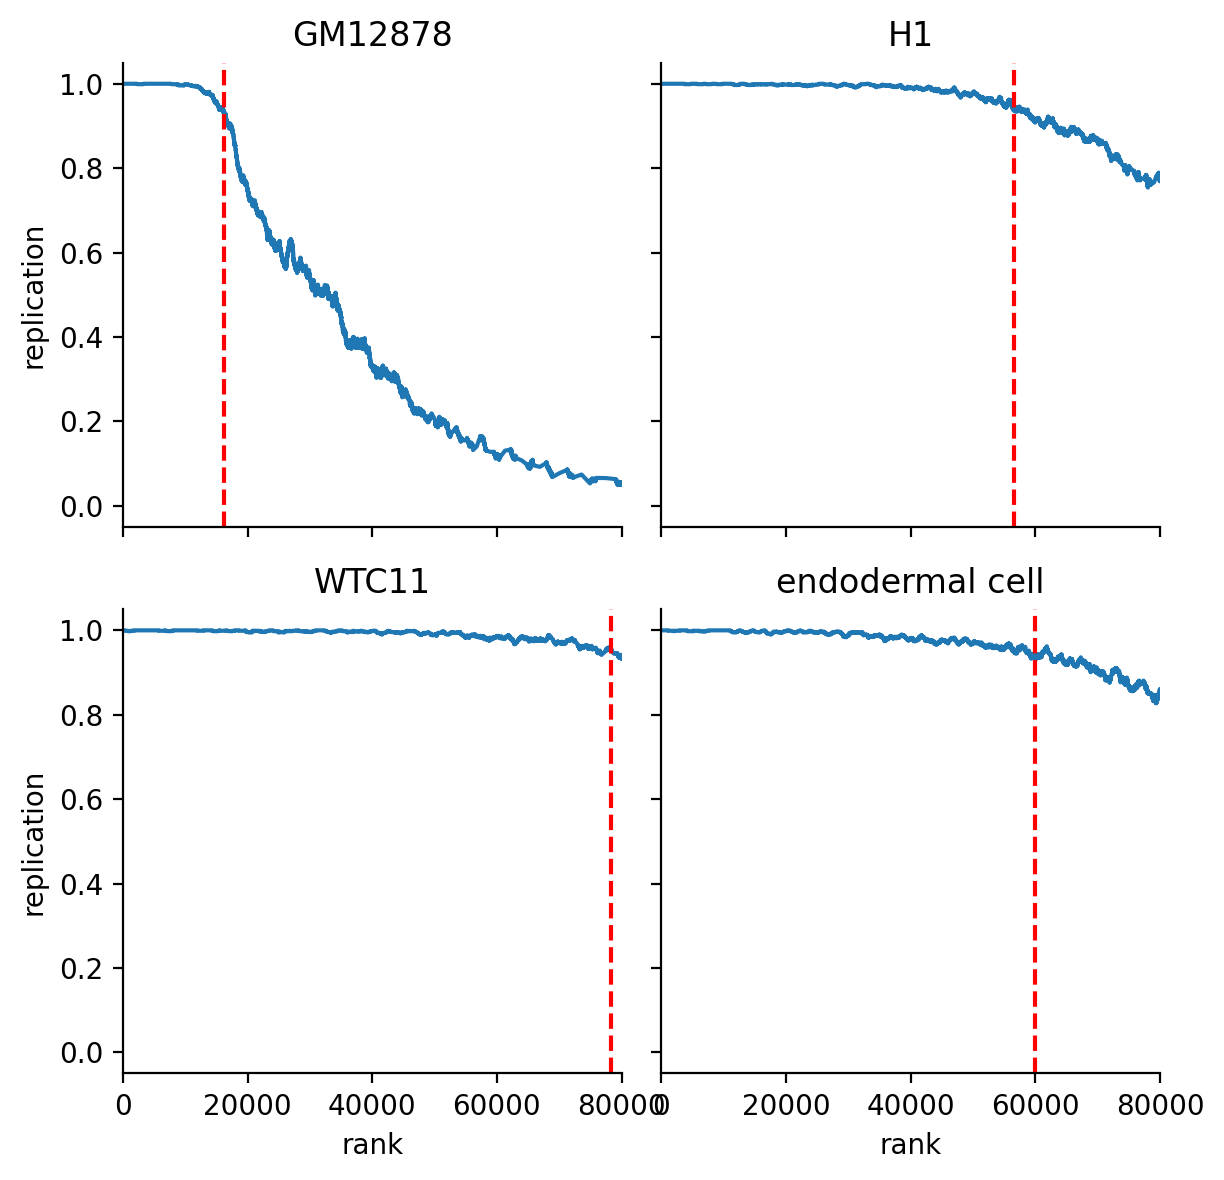

In [11]:
from more_itertools import flatten

_core_cols = ['Chromosome', 'Start', 'End', 'Strand']

n = 0

fig, axs = plt.subplots(2, 2, dpi=200, figsize=(6, 6), sharey=True, sharex=True)
axs = list(flatten(axs))

for ax in axs:
    ax.set_axis_off()

for dataset in tqdm(lapa.datasets):
    samples = get_samples(dataset)
    
    if len(samples) < 2:
        continue

    lapa.plot_replication_rate(samples=samples, num_samples=len(samples), line_kws={'ax': axs[n]})
    
    num_replicated = lapa.read_dataset(dataset).drop_duplicates(_core_cols).shape[0]

    axs[n].axvline(x=num_replicated, c='r', linestyle='--')

    axs[n].set_title(f'{dataset}')
    axs[n].set_axis_on()
    
    n += 1
    
fig.tight_layout()
sns.despine()
plt.xlim((0, 80_000))

plt.savefig(snakemake.output['fig_replication'], bbox_inches = "tight")